# Project Adv ML

In [11]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy
from scipy import special
import pandas as pd

### Setup

## Load the Document Corpus
Download the data from 
https://github.com/Blei-Lab/lda-c/blob/master/example/ap.tgz

We can directly load the file "ap.dat" which contains:

1 line = 1 document,

[number of different words in doc] [word index (where the one is in w_n]:[how often it occurs in the doc] [word index 2]:[occurences 2] ...

In [12]:
vocab = pd.read_csv("./ap/vocab.txt", header=None)
V = vocab.shape[0] # Vocab Size given by vocab_list.txt
# vocab.head(10)

In [40]:
data = pd.read_csv('ap/ap.dat', sep="#", names=['A'])
M = data_np.shape[0]
data = data.A.str.split(' ')
doc_word_count = np.zeros((M, V))

for j, m in enumerate(data):
    count = m.pop(0)
    for i in range(int(count)):
        type(m[i])
        cur = m[i].split(":")
        doc_word_count[j][int(cur[0])] = int(cur[1])
        


array([1., 0., 0., ..., 0., 0., 0.])

In [42]:
data = pd.read_csv('ap/ap.dat', sep="#", names=['A'])



data = data.A.str.split(' |:', n=V, expand=True)
data.head()
data_np = data.values


In [49]:
D = []  # this has dim: M x 2 (words and counts) x N_words(document)
for w in range(M): # for each document
    doc_string = data_np[w,:]
    #print(len(doc_string))
    word_indices = doc_string[1::2]
    #print("word_indices", word_indices)
    counts = doc_string[2::2]
    #if w==1:
    #  print(len(word_indices), len(counts))
    #print("counts", counts)
    N_different_words_in_this_doc = doc_string[0] # not needed.
    D.append([])
    all_words = []
    for n,word in enumerate(word_indices):
        if word==None:
            break
        for repetition in range(int(counts[n])):
            #if int(counts[n])>1:
            #  print(word, counts[n])
            all_words.append(int(word))
    D[-1]=all_words
  # NOTE: D does not contain M docs with each N_d words, where each word w_n is a V-dim vector.
  # BUT:              it has M docs with each N_d words, where each word is just the unique index v, that is one of the V-dim vector.
  # Reason: V=10,000...



2246
263


TypeError: object of type 'int' has no len()

Text(0, 0.5, 'count')

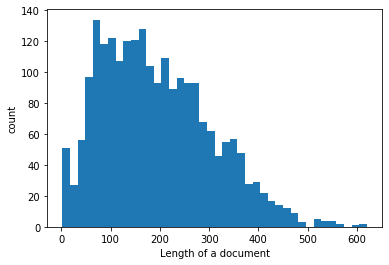

In [285]:
lengths = []
for i in range(len(D)):
    lengths.append(len(D[i]))
p = plt.hist(lengths, bins=40)
plt.xlabel("Length of a document")
plt.ylabel("count")

## Remove the standard words

### Variational Inference (the E-Step)

In [335]:
def updateGammaPhi(k, alpha, beta, w, tol=10**(-5), MAX_STEPS=100, verbose=False):
    ''' This implements the update equations for Gamma and Phi for a variational inference step.
     Inputs: 
        k=int=nr of topics;  
        alpha=[k]-vec=priors_of_theta(mixture_weights);  
        beta=[NxV]-matrix=prob_of_word_v_given_topic_
    '''
    N = len(w)
    # Init    
    phi = 1/k * np.ones([N,k])
    gamma = alpha + np.ones([k]) * N/k 
    
    q_old = compute_lower_bound_likelihood(w,k,phi,gamma, alpha, beta, verbose = verbose)
    converged = False
    
    #Loop
    security_count=0
    
    while (not converged) and (security_count < MAX_STEPS):
        security_count+=1
        
        phi_old = np.copy(phi)
        logphi = np.zeros_like(phi)
        gamma_old = np.copy(gamma)
        
        for n in range(N):
            for i in range(k):
                w_n = w[n] ## this is not a V-Vector, but just the index of the word in the vocab
                #beta_iv is p(w_n^v = 1 | z^i = 1) 
                v = w_n   #unique v for each word w_n
                
                ### TRICK: instead of phi=beta+e^{psi(gamma)}, do 
                logphi[n,i] = np.log(beta[i,v]) + (psi(gamma_old[i]))#
                phi[n,i] = np.exp(logphi[n,i])
                
            #normalize Phi: s.t. for each topic the sum of phi[n,:] is 1.
            phi[n,:] = phi[n,:]/np.sum(phi[n,:])
        gamma = alpha + np.sum(phi,axis=0)
       
        # Convergence criterion is: lower bound of likleihood
        q_new = compute_lower_bound_likelihood(w,k,phi,gamma, alpha, beta, verbose=verbose)
        #print("Liks, ", q_new, q_old)#,  compute_lda_lhood(w,phi,gamma,alpha,beta,k))
        if abs(q_new-q_old)/q_old < tol:
            converged = True
        else: 
            q_old=np.copy(q_new)
        
    return q_new, gamma, phi

def psi(gamma_i):
    # this is the first derivative (via Taylor approximation) of the log \Gamma function
    # according to Wikipedia this is the "digamma" function
    return scipy.special.digamma(gamma_i)



In [336]:
def compute_lower_bound_likelihood(w,k,phi,gamma, alpha, beta, verbose=False):
    '''
    This calculate the lower bound of L(gamma, phi, alpha, beta)
    Ie. equation 15 in the paper in Appendix 3.
    Only one 
    '''
    
    N = len(w)
    global V # length of the vocab
    
    loggamma_sum = lambda x: scipy.special.gammaln(np.sum(x))
    loggamma_x_i = lambda x, i: np.log(scipy.special.gamma(x[i]))
    E_log_thetai_givenGamma = lambda i:  (psi(gamma[i]) - psi(np.sum(gamma))) 

    #print("gamma, alpha= ", gamma,alpha)
    L = loggamma_sum(alpha) - loggamma_sum(gamma)
    #if verbose: print("#0: ", L, end=", ")
    for i in range(k):
        L += -loggamma_x_i(alpha,i) + (alpha[i]-1)*E_log_thetai_givenGamma(i)
        L += +loggamma_x_i(gamma,i) - (gamma[i]-1)*E_log_thetai_givenGamma(i)
        #if verbose: print("#",i,": ", L, end=", ")
        for n in range(N):
            L+= phi[n,i] * E_log_thetai_givenGamma(i)
            L+= - phi[n,i] *np.log(phi[n,i])
            v = w[n] # here w_n is not a vector
            L+= phi[n,i] * np.log(beta[i,v]) 
            #if verbose: print("#",i,",",n,": ", L, ", v=",v, end=", ")
    if verbose: print(L, "\n")
    return L
    

In [337]:
def E_step(k, alpha,beta, MAX_COUNTER=10, verbose=False):
    gamma_list = []
    phi_list = []
    counter=0
    likelihood_list = []
    for d, doc in enumerate(D):
        counter+=1
        # doc is a N_d Vector containing indices of all words
        if verbose: print("Doc: "+str(d)+" ("+str(len(doc))+")", end=", ")#, len(doc[0]))
        likelihood, gamma, phi = updateGammaPhi(k,alpha,beta,doc, verbose=verbose)
        gamma_list.append(gamma)
        phi_list.append(phi)
        likelihood_list.append(likelihood)
        # Stop this if sufficient statistics (how do i know this?)
        if verbose and counter%10 ==0:
            print(gamma, likelihood)
        # calculate the approximate q(theta, z | gamma, phi)
        if counter> MAX_COUNTER:
            break
    return likelihood_list, gamma_list, phi_list


## M-Step

In [338]:
# def M_step(): 

SyntaxError: unexpected EOF while parsing (<ipython-input-338-bc2016d8a2a2>, line 2)

## Initialisation

In [340]:
k= 4
V= 10473

alpha=np.ones([k])*0.01

beta = np.zeros([k,V])+0.01


In [343]:
likelihood_list, gamma_list, phi_list = \
    E_step(k,alpha,beta, MAX_COUNTER=100, verbose=False) # MAX_COUNTER == Training set size

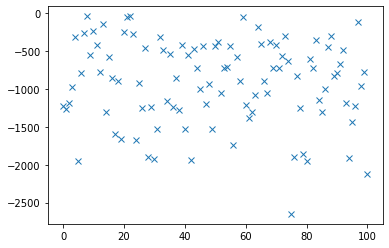

In [342]:
plt.plot(likelihood_list, 'x')